## **1. Importar Librerias y Cargar Datos:**

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


In [ ]:
df = pd.read_csv("heart.csv")
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


### **1.1. Funciones:**

In [ ]:
def prueba_Normalidad(datos, alpha=0.05):
    # Eliminar valores NaN y asegurar tipo numérico
    datos = np.array(datos, dtype=float)
    datos = datos[~np.isnan(datos)]

    # Aplicar prueba de Kolmogorov–Smirnov
    stat, p = kstest(datos, 'norm', args=(np.mean(datos), np.std(datos)))

    # Resultados
    print("=== Prueba de Normalidad Kolmogorov–Smirnov ===")
    print(f"Estadístico D = {stat:.4f}")
    print(f"p-value = {p:.20f}\n")

    # Interpretación
    if p > alpha:
        print("✅ Conclusión:")
        print(f"No se rechaza H₀ (p > {alpha}).")
        print("Los datos podrían provenir de una distribución normal.")
    else:
        print("❌ Conclusión:")
        print(f"Se rechaza H₀ (p ≤ {alpha}).")
        print("Los datos NO siguen una distribución normal.")



## **2. Exploración Inicial de los Datos:**

### **2.1. Observar Valores:**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


Note que la base de datos cuenta con una dimensiín de `918 filas` por `12 columnas`. Al parecer no hay datos faltantes. Sin embargo, note que algunas variables estan mal tipificadas, lo cual, debemos corregir.

Ahora, observemos la base de datos.

In [ ]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [ ]:
df.tail()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1
917,38,M,NAP,138,175,0,Normal,173,N,0.0,Up,0


A simple vista no hay errores o valores faltantes. Sin embargo, hay que verificar que no haya algun error de registro.

In [ ]:
df["ST_Slope"].unique()

array(['Up', 'Flat', 'Down'], dtype=object)

In [ ]:
df["Sex"].unique()

array(['M', 'F'], dtype=object)

In [ ]:
df["ChestPainType"].unique()

array(['ATA', 'NAP', 'ASY', 'TA'], dtype=object)

In [ ]:
df["RestingECG"].unique()

array(['Normal', 'ST', 'LVH'], dtype=object)

In [ ]:
df["ExerciseAngina"].unique()

array(['N', 'Y'], dtype=object)

In [ ]:
df["Age"].unique()

array([40, 49, 37, 48, 54, 39, 45, 58, 42, 38, 43, 60, 36, 44, 53, 52, 51,
       56, 41, 32, 65, 35, 59, 50, 47, 31, 46, 57, 55, 63, 66, 34, 33, 61,
       29, 62, 28, 30, 74, 68, 72, 64, 69, 67, 73, 70, 77, 75, 76, 71])

In [ ]:
df["RestingBP"].unique()

array([140, 160, 130, 138, 150, 120, 110, 136, 115, 100, 124, 113, 125,
       145, 112, 132, 118, 170, 142, 190, 135, 180, 108, 155, 128, 106,
        92, 200, 122,  98, 105, 133,  95,  80, 137, 185, 165, 126, 152,
       116,   0, 144, 154, 134, 104, 139, 131, 141, 178, 146, 158, 123,
       102,  96, 143, 172, 156, 114, 127, 101, 174,  94, 148, 117, 192,
       129, 164])

En este caso, encontramos un valor extraño, ya que es fisiológicamente imposible que una presión arterial sea de 0 mmHg, pues esto implicaría la ausencia total de presión sanguínea, lo cual no es compatible con la vida. Por lo tanto, este dato debe ser considerado como NA.

In [ ]:
df["Cholesterol"].unique()

array([289, 180, 283, 214, 195, 339, 237, 208, 207, 284, 211, 164, 204,
       234, 273, 196, 201, 248, 267, 223, 184, 288, 215, 209, 260, 468,
       188, 518, 167, 224, 172, 186, 254, 306, 250, 177, 227, 230, 294,
       264, 259, 175, 318, 216, 340, 233, 205, 245, 194, 270, 213, 365,
       342, 253, 277, 202, 297, 225, 246, 412, 265, 182, 218, 268, 163,
       529, 100, 206, 238, 139, 263, 291, 229, 307, 210, 329, 147,  85,
       269, 275, 179, 392, 466, 129, 241, 255, 276, 282, 338, 160, 156,
       272, 240, 393, 161, 228, 292, 388, 166, 247, 331, 341, 243, 279,
       198, 249, 168, 603, 159, 190, 185, 290, 212, 231, 222, 235, 320,
       187, 266, 287, 404, 312, 251, 328, 285, 280, 192, 193, 308, 219,
       257, 132, 226, 217, 303, 298, 256, 117, 295, 173, 315, 281, 309,
       200, 336, 355, 326, 171, 491, 271, 274, 394, 221, 126, 305, 220,
       242, 347, 344, 358, 169, 181,   0, 236, 203, 153, 316, 311, 252,
       458, 384, 258, 349, 142, 197, 113, 261, 310, 232, 110, 12

Para la variable ``cholesterol``, también encontramos un valor de 0, lo cual es fisiológicamente imposible. Por lo tanto, este valor se considera un error y será tratado como un dato faltante.

In [ ]:
df["FastingBS"].unique()

array([0, 1])

In [ ]:
df["MaxHR"].unique()

array([172, 156,  98, 108, 122, 170, 142, 130, 120,  99, 145, 140, 137,
       150, 166, 165, 125, 160, 164, 138, 178, 112, 118, 127, 114, 154,
       155,  87, 148, 100, 168, 184, 121, 153, 134,  96, 174, 175, 144,
        82, 135, 115, 128, 116,  94, 110,  92, 180, 152, 124, 106, 185,
       139, 190, 146, 158, 132, 176, 119, 188, 162, 105,  90, 136, 167,
       129, 102, 143, 103,  91, 126,  93, 131, 149, 123, 182, 141,  77,
       109, 133, 179, 113, 104,  95,  72,  97, 117,  86,  63, 157,  83,
        60,  70, 163,  67,  78,  84, 111,  80, 107, 161,  69,  88,  73,
       159, 151, 181, 186, 177, 173, 169, 171, 147,  71, 192, 195, 194,
       187, 202])

In [ ]:
df["Oldpeak"].unique()

array([ 0. ,  1. ,  1.5,  2. ,  3. ,  4. ,  0.5,  2.5,  5. ,  0.8,  0.7,
        1.4,  2.1,  0.4,  0.2,  1.7,  2.2,  0.1,  1.6,  1.3,  0.3,  1.8,
        2.6, -0.9,  2.8, -2.6, -1.5, -0.1,  0.9,  1.1,  2.4, -1. , -1.1,
       -0.7, -0.8,  3.7,  1.2, -0.5, -2. ,  1.9,  3.5,  0.6,  3.1,  2.3,
        3.4,  3.6,  4.2,  3.2,  5.6,  3.8,  2.9,  6.2,  4.4])

### **2.2. Corrección y Tratamiento de Valores Faltantes:**

In [ ]:
# Cambiar tipos de datos en el DataFrame
df = df.astype({
    'Age': 'int64',
    'Sex': 'category',
    'ChestPainType': 'category',
    'RestingBP': 'float64',
    'Cholesterol': 'float64',
    'FastingBS': 'category',
    'RestingECG': 'category',
    'MaxHR': 'int64',
    'ExerciseAngina': 'category',
    'Oldpeak': 'float64',
    'ST_Slope': 'category',
    'HeartDisease': 'category'
})

# Verificación
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Age             918 non-null    int64   
 1   Sex             918 non-null    category
 2   ChestPainType   918 non-null    category
 3   RestingBP       918 non-null    float64 
 4   Cholesterol     918 non-null    float64 
 5   FastingBS       918 non-null    category
 6   RestingECG      918 non-null    category
 7   MaxHR           918 non-null    int64   
 8   ExerciseAngina  918 non-null    category
 9   Oldpeak         918 non-null    float64 
 10  ST_Slope        918 non-null    category
 11  HeartDisease    918 non-null    category
dtypes: category(7), float64(3), int64(2)
memory usage: 43.2 KB


Reemplazamos los errores que encontramos con NaN

In [ ]:
df["RestingBP"] = df["RestingBP"].replace(0, np.nan)
df["Cholesterol"] = df["Cholesterol"].replace(0, np.nan)

Realizamos un mapa de calor para identificar los valores faltantes

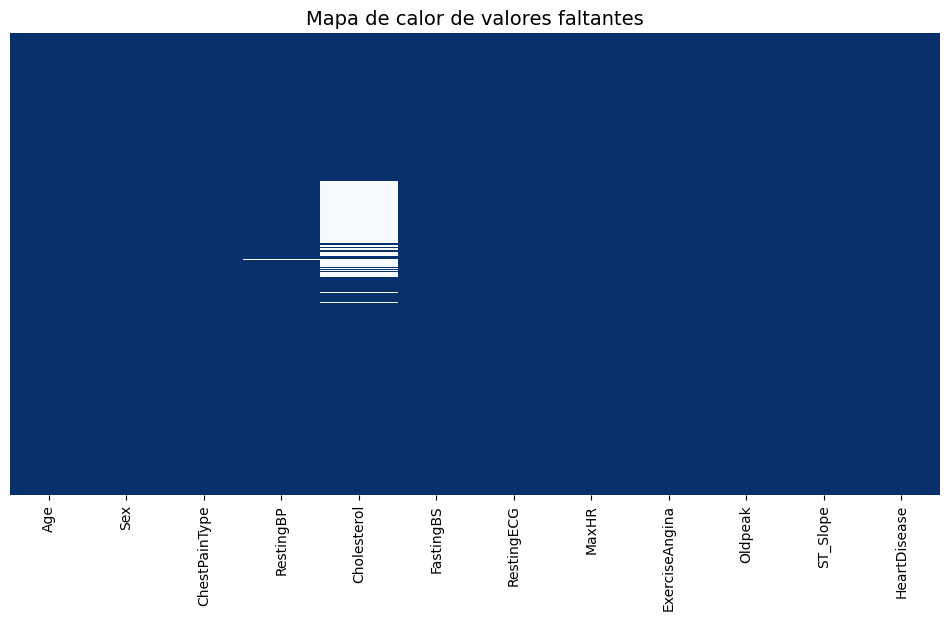

In [ ]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='Blues_r')
plt.title("Mapa de calor de valores faltantes", fontsize=14)
plt.show()

In [ ]:
faltantes = df.isnull().sum()
porcentaje = (faltantes / len(df)) * 100

tabla_faltantes = pd.DataFrame({
    'Valores faltantes': faltantes,
    'Porcentaje (%)': porcentaje
})

# Mostrar solo columnas con NA
tabla_faltantes = tabla_faltantes[tabla_faltantes['Valores faltantes'] > 0]
tabla_faltantes.sort_values('Porcentaje (%)', ascending=False)

,Valores faltantes,Porcentaje (%)
Cholesterol,172,18.736383
RestingBP,1,0.108932


#### **2.2.1.  Tratamiento:**

In [ ]:
prueba_Normalidad(df["RestingBP"])

=== Prueba de Normalidad Kolmogorov–Smirnov ===
Estadístico D = 0.0993
p-value = 0.00000002533875609008

❌ Conclusión:
Se rechaza H₀ (p ≤ 0.05).
Los datos NO siguen una distribución normal.


In [ ]:
prueba_Normalidad(df["Cholesterol"])

=== Prueba de Normalidad Kolmogorov–Smirnov ===
Estadístico D = 0.0565
p-value = 0.01648782178779727159

❌ Conclusión:
Se rechaza H₀ (p ≤ 0.05).
Los datos NO siguen una distribución normal.


Dado que los datos no siguen una distribución normal y considerando el porcentaje de valores faltantes, procederemos a imputar utilizando la mediana, ya que es más robusta para datos no normales.


In [ ]:
df["RestingBP"].fillna(df["RestingBP"].median(), inplace=True)
df["Cholesterol"].fillna(df["Cholesterol"].median(), inplace=True)

C:\Users\taran\AppData\Local\Temp\ipykernel_8560\1832118684.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["RestingBP"].fillna(df["RestingBP"].median(), inplace=True)
C:\Users\taran\AppData\Local\Temp\ipykernel_8560\1832118684.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a co

## **3. EDA:**

### **3.1. Análisis de Numéricas:**

In [ ]:
df.describe(exclude="category")

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
count,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.538126,243.204793,136.809368,0.887364
std,9.432617,17.990127,53.401297,25.460334,1.066570
min,28.000000,80.000000,85.000000,60.000000,-2.600000
25%,47.000000,120.000000,214.000000,120.000000,0.000000
50%,54.000000,130.000000,237.000000,138.000000,0.600000
75%,60.000000,140.000000,267.000000,156.000000,1.500000
max,77.000000,200.000000,603.000000,202.000000,6.200000


En general, las estadísticas descriptivas muestran que los pacientes tienen una **edad promedio de 53.5 años**, con una distribución bastante homogénea (rango entre 28 y 77 años). La **presión arterial en reposo (RestingBP)** tiene un valor medio de **132.5 mm Hg**, dentro de los rangos clínicamente normales, aunque con algunos valores altos que alcanzan hasta 200 mm Hg. El **colesterol** presenta una media de **243 mg/dl**, lo que sugiere que muchos pacientes podrían tener niveles elevados, y su máximo de **603 mg/dl** confirma la presencia de casos extremos. La **frecuencia cardíaca máxima (MaxHR)** promedia **137 latidos por minuto**, con una variación moderada entre 60 y 202, lo que refleja diferencias individuales esperadas por edad y condición física. Finalmente, la variable **Oldpeak**, que mide la depresión del segmento ST, muestra una mediana baja (0.6) y valores atípicos hacia ambos extremos (de -2.6 a 6.2), indicando que la mayoría de los pacientes presentan poca o ninguna depresión ST, mientras que unos pocos casos muestran anomalías más pronunciadas.


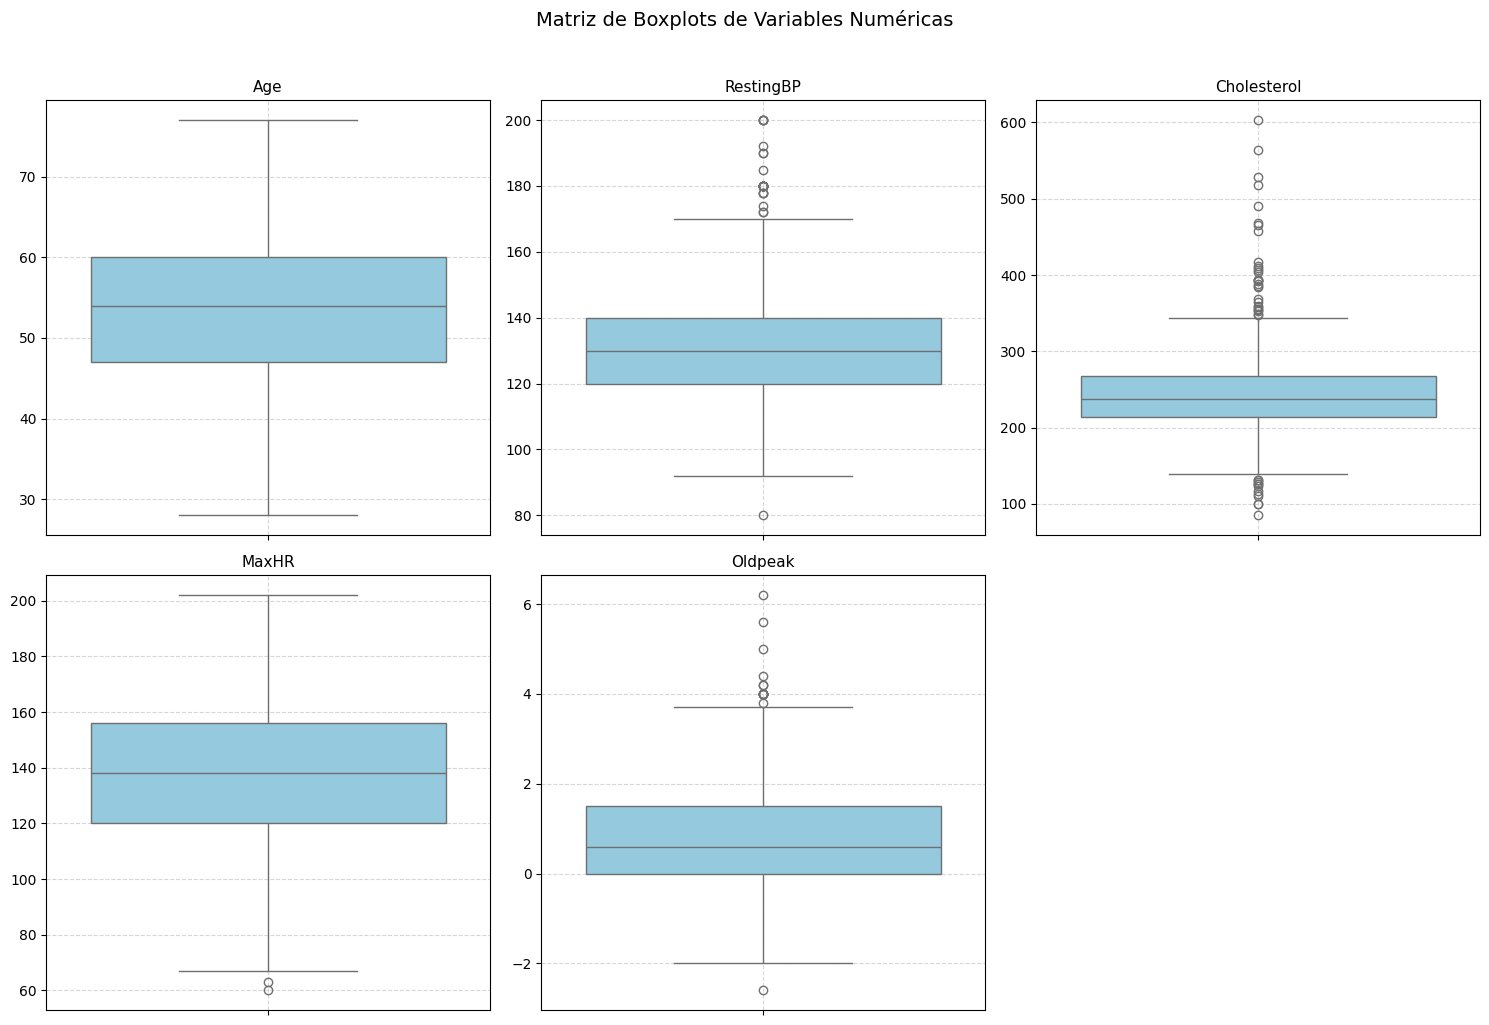

In [ ]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Configurar número de filas y columnas en la matriz
n_cols = 3
n_rows = int(np.ceil(len(num_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
axes = axes.flatten()

# Crear los boxplots
for i, col in enumerate(num_cols):
    sns.boxplot(y=df[col], ax=axes[i], color='skyblue')
    axes[i].set_title(f'{col}', fontsize=11)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].grid(True, linestyle='--', alpha=0.5)

# Eliminar ejes vacíos si sobran
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Matriz de Boxplots de Variables Numéricas', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


 En general, las variables **Age** y **MaxHR** presentan distribuciones bastante simétricas y sin outliers relevantes, lo que indica una buena consistencia en los datos. **RestingBP** y **Cholesterol** muestran varios valores atípicos, especialmente el colesterol, con registros significativamente altos que podrían corresponder a casos clínicamente relevantes o a errores de medición. Por último, **Oldpeak** presenta algunos valores extremos hacia ambos lados, aunque su rango intercuartílico es estrecho, lo que sugiere que la mayoría de los pacientes se concentran cerca de valores bajos. En conjunto, los gráficos confirman que, aunque existen algunos valores atípicos, el comportamiento general de las variables es razonable y representativo.

Como análisis complementario, se procederá a identificar el porcentaje de outliers con el fin de evaluar su posible influencia en los resultados.


In [ ]:
# Diccionario para guardar los resultados
outliers_info = {}

# Detectar outliers usando el método del rango intercuartílico (IQR)
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    # Límites inferior y superior
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    
    # Identificar los índices de los outliers
    outliers = df[(df[col] < lower_limit) | (df[col] > upper_limit)][col]
    
    # Guardar resumen
    outliers_info[col] = {
        'Total de outliers': len(outliers),
        'Porcentaje (%)': round(100 * len(outliers) / len(df), 2),
        'Límite inferior': round(lower_limit, 2),
        'Límite superior': round(upper_limit, 2)
    }

# Convertir el resultado a DataFrame para visualizar mejor
outliers_df = pd.DataFrame(outliers_info).T
outliers_df

,Total de outliers,Porcentaje (%),Límite inferior,Límite superior
Age,0.0,0.00,27.50,79.50
RestingBP,27.0,2.94,90.00,170.00
Cholesterol,41.0,4.47,134.50,346.50
MaxHR,2.0,0.22,66.00,210.00
Oldpeak,16.0,1.74,-2.25,3.75


El conjunto de datos muestra una baja incidencia de valores atípicos (todos por debajo del 5%), por lo que no es necesario eliminarlos de forma automática.

### **3.2. Análisis Variables Categoricas:**

In [ ]:
df.describe(include="category")

,Sex,ChestPainType,FastingBS,RestingECG,ExerciseAngina,ST_Slope,HeartDisease
count,918,918,918,918,918,918,918
unique,2,4,2,3,2,3,2
top,M,ASY,0,Normal,N,Flat,1
freq,725,496,704,552,547,460,508


El resumen muestra las características **categóricas** del conjunto de datos de pacientes. La mayoría de los registros corresponden a **hombres (725 de 918 casos)**. En cuanto al tipo de dolor en el pecho (**ChestPainType**), el más frecuente es el tipo **ASY (asintomático)**, presente en **496 pacientes**, lo cual sugiere que muchos de ellos no presentan dolor típico pese a tener enfermedad cardíaca. La variable **FastingBS** (azúcar en sangre en ayunas) indica que **704 pacientes tienen niveles normales (0)**, mientras que el resto presenta valores elevados. El **electrocardiograma en reposo (RestingECG)** muestra que la categoría **Normal** es la más común (**552 casos**). Respecto a la **angina inducida por ejercicio (ExerciseAngina)**, la mayoría **no la presenta (N = 547 casos)**. En la variable **ST_Slope**, que describe la pendiente del segmento ST durante el esfuerzo, la categoría predominante es **Flat (460 casos)**, asociada frecuentemente con riesgo cardíaco. Finalmente, la variable **HeartDisease** indica que **508 pacientes (55%) presentan enfermedad cardíaca**, lo que refleja un conjunto de datos equilibrado pero con ligera mayoría de casos positivos.



C:\Users\taran\AppData\Local\Temp\ipykernel_8560\568683847.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, ax=axes[i], palette="Set2")
C:\Users\taran\AppData\Local\Temp\ipykernel_8560\568683847.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, ax=axes[i], palette="Set2")
C:\Users\taran\AppData\Local\Temp\ipykernel_8560\568683847.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, ax=axes[i], palette="Set2")
C:\Users\taran\AppData\Local\Temp\ipykernel_8560\568683847.py:13: FutureW

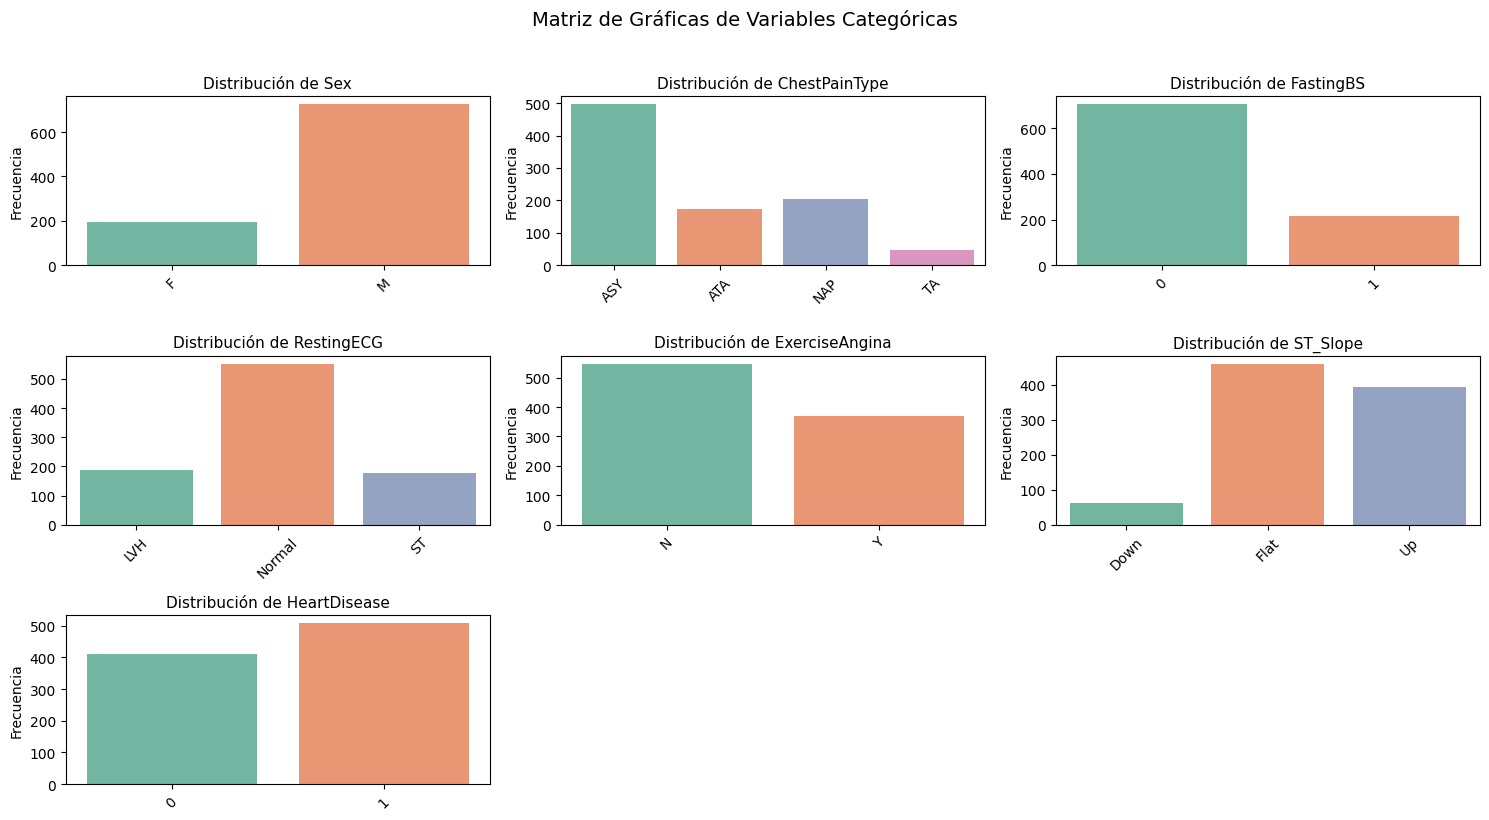

In [ ]:
# Seleccionar columnas categóricas
cat_cols = df.select_dtypes(include=['category']).columns

# Configurar tamaño de figura y número de columnas
n_cols = 3
n_rows = int(np.ceil(len(cat_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 8))
axes = axes.flatten()

# Crear un gráfico por cada variable categórica
for i, col in enumerate(cat_cols):
    sns.countplot(x=col, data=df, ax=axes[i], palette="Set2")
    axes[i].set_title(f'Distribución de {col}', fontsize=11)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Frecuencia')
    axes[i].tick_params(axis='x', rotation=45)

# Eliminar ejes vacíos si sobran
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Matriz de Gráficas de Variables Categóricas', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

Se observa una clara **predominancia del sexo masculino**, con una mayor proporción de hombres frente a mujeres. En cuanto al **tipo de dolor en el pecho**, la mayoría de los pacientes presentan el tipo **asintomático (ASY)**, lo que indica que muchos no manifiestan dolor evidente pese a su condición. La variable **FastingBS** revela que la mayoría no presenta niveles altos de azúcar en sangre. En el **electrocardiograma en reposo (RestingECG)**, la categoría **Normal** es la más común. Además, la **angina inducida por ejercicio (ExerciseAngina)** aparece mayoritariamente como negativa (N), indicando ausencia de síntomas durante el esfuerzo. Respecto a la **pendiente del segmento ST (ST_Slope)**, predominan los valores **Flat** y **Up**, asociados con distintos niveles de riesgo cardíaco. Finalmente, la variable **HeartDisease** muestra una ligera mayoría de pacientes con enfermedad cardíaca, sugiriendo un equilibrio razonable entre ambos grupos para el análisis.


### **3.3. Análisis Bivariado:**

#### **3.3.1. Numéricas Vs Categoricas:**

C:\Users\taran\AppData\Local\Temp\ipykernel_8560\2922830290.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='HeartDisease', y=var, data=df, ax=axes[0, i], palette='Set2')
C:\Users\taran\AppData\Local\Temp\ipykernel_8560\2922830290.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='HeartDisease', y=var, data=df, ax=axes[0, i], palette='Set2')
C:\Users\taran\AppData\Local\Temp\ipykernel_8560\2922830290.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='HeartDisease', y=var, data=df, ax=axes[0, i], palette='Set2')
C:\Users\taran\A

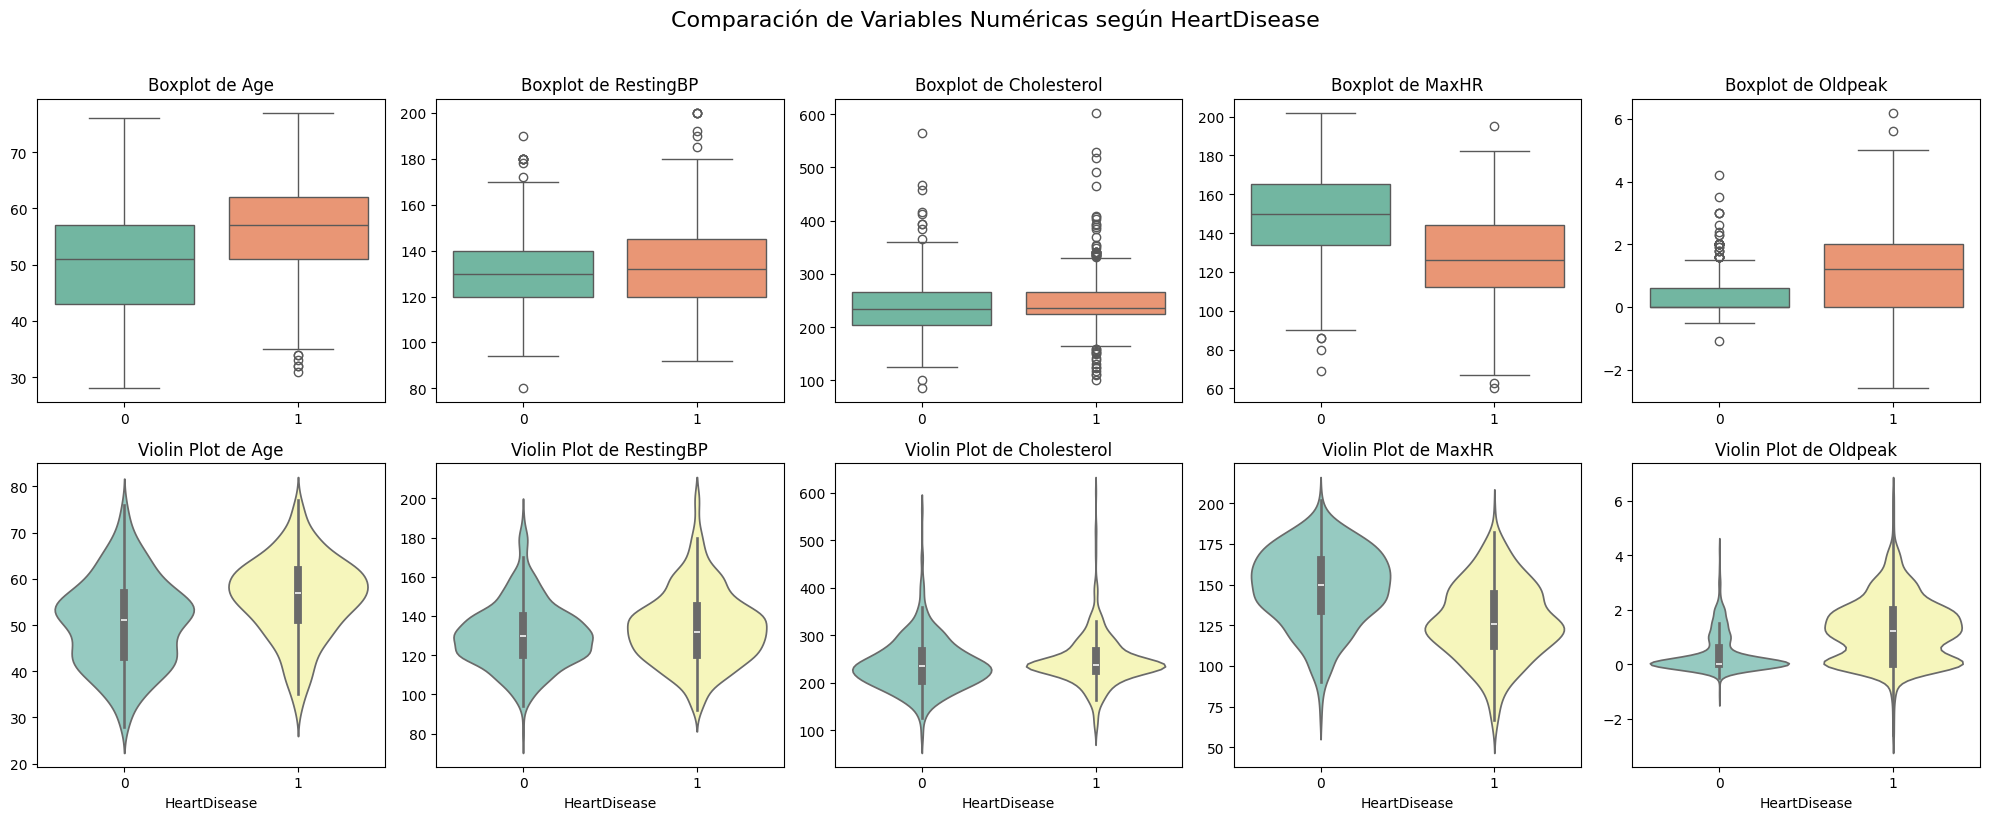

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=len(num_cols), figsize=(20, 8))
fig.suptitle('Comparación de Variables Numéricas según HeartDisease', fontsize=16, y=1.02)

# Gráficos tipo Boxplot (fila 1)
for i, var in enumerate(num_cols):
    sns.boxplot(x='HeartDisease', y=var, data=df, ax=axes[0, i], palette='Set2')
    axes[0, i].set_title(f'Boxplot de {var}')
    axes[0, i].set_xlabel('')
    axes[0, i].set_ylabel('')

# Gráficos tipo Violín Plot (fila 2)
for i, var in enumerate(num_cols):
    sns.violinplot(x='HeartDisease', y=var, data=df, ax=axes[1, i], palette='Set3')
    axes[1, i].set_title(f'Violin Plot de {var}')
    axes[1, i].set_xlabel('HeartDisease')
    axes[1, i].set_ylabel('')

plt.tight_layout()
plt.show()

En general, los gráficos muestran diferencias notables entre los grupos con y sin enfermedad cardíaca. Se observa que las personas con **HeartDisease = 1** tienden a tener **mayor edad**, **mayores valores de Oldpeak** (indicando posibles alteraciones en el ECG bajo esfuerzo) y **menores valores de MaxHR** (frecuencia cardíaca máxima alcanzada), lo cual es coherente con un menor rendimiento cardiovascular. Por otro lado, las variables **RestingBP** y **Cholesterol** no presentan diferencias marcadas entre ambos grupos, aunque en ambos casos existen algunos valores atípicos. En conjunto, los resultados sugieren que las variables **Age**, **MaxHR** y **Oldpeak** son las que más discriminan entre individuos con y sin enfermedad cardíaca, mientras que las demás tienen un comportamiento más homogéneo.


#### **3.3.2. Categoricas Vs Categoricas:**

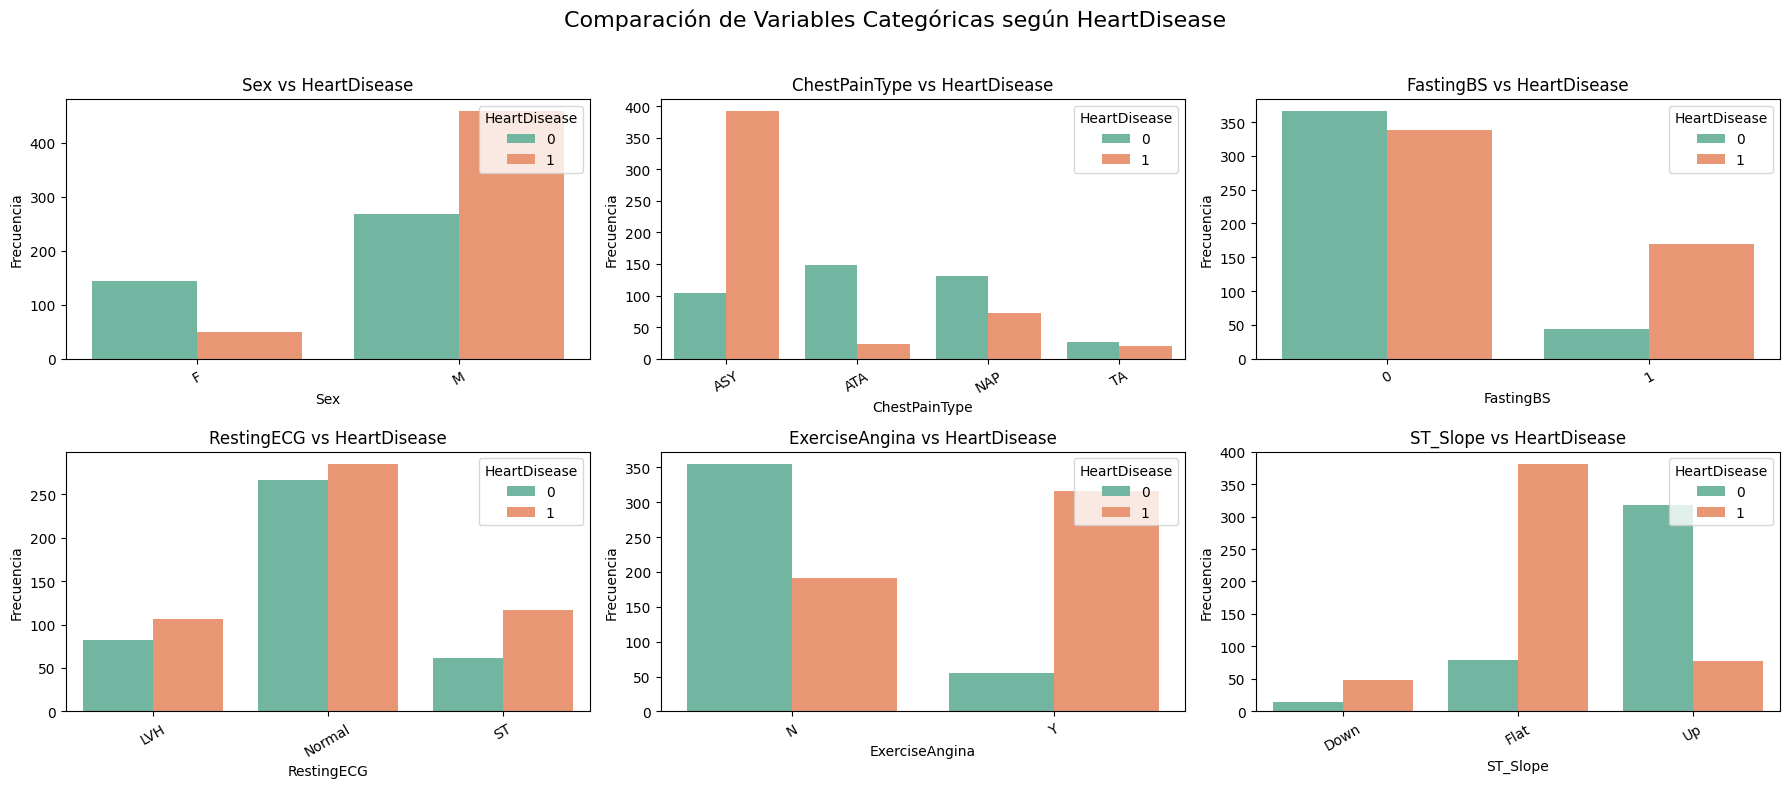

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
fig.suptitle('Comparación de Variables Categóricas según HeartDisease', fontsize=16)

for ax, var in zip(axes.flat, cat_cols):
    # Crear gráfico de barras agrupadas
    sns.countplot(data=df, x=var, hue='HeartDisease', ax=ax, palette='Set2')
    ax.set_title(f'{var} vs HeartDisease')
    ax.set_xlabel(var)
    ax.set_ylabel('Frecuencia')
    ax.legend(title='HeartDisease', loc='upper right')
    ax.tick_params(axis='x', rotation=30)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

En general, los gráficos de variables categóricas muestran diferencias notables entre los grupos con y sin enfermedad cardíaca. Se observa que las personas con **HeartDisease = 1** presentan distribuciones distintas en categorías como **ChestPainType** (con mayor proporción de dolor tipo "ATA" en sanos y "ASY" en enfermos), **ST_Slope** (donde la pendiente "Flat" o "Down" es más frecuente en enfermos) y **Sex** (con mayor proporción de hombres en el grupo con enfermedad). Por otro lado, variables como **RestingECG** muestran un comportamiento más homogéneo entre ambos grupos, sin diferencias marcadas en sus categorías. En conjunto, los resultados sugieren que **ChestPainType**, **ST_Slope** y **Sex** son las variables categóricas que más discriminan entre individuos con y sin enfermedad cardíaca, mientras que **RestingECG** tiene un poder diferenciador limitado.

#### **3.3.3. Numéricas Vs Númericas:**

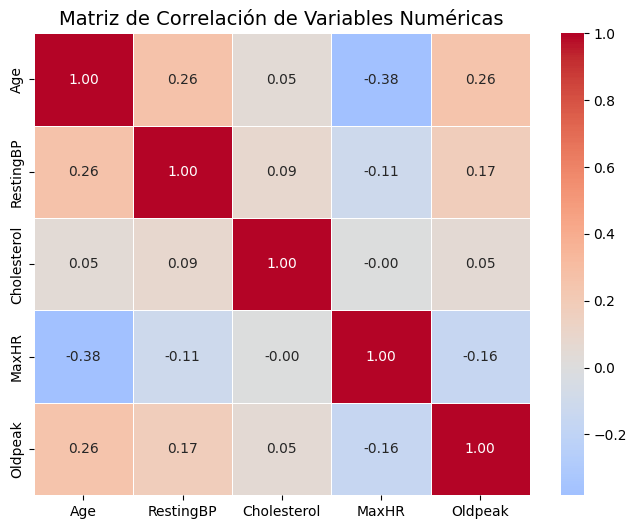

In [ ]:
# Calculamos la matriz de correlación
corr_matrix = df[num_cols].corr()

# Creamos el heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlación de Variables Numéricas', fontsize=14)
plt.show()

En general, la matriz de correlación revela que las relaciones lineales entre las variables numéricas son en su mayoría débiles. La correlación más fuerte se observa entre **Age** y **MaxHR**, que presenta un valor de -0.38, indicando una relación inversa moderada donde a mayor edad, menor tiende a ser la frecuencia cardíaca máxima alcanzada. Otras correlaciones notables, aunque más débiles, son las de **Age** con **Oldpeak** (0.26) y **RestingBP** con **Oldpeak** (0.17), sugiriendo que una mayor edad y una presión arterial en reposo más alta podrían estar ligeramente asociadas con un valor de Oldpeak más elevado. Por el contrario, variables como **Cholesterol** muestran correlaciones prácticamente nulas con todas las demás (valores cercanos a 0), lo que indica su independencia lineal dentro de este conjunto de datos.

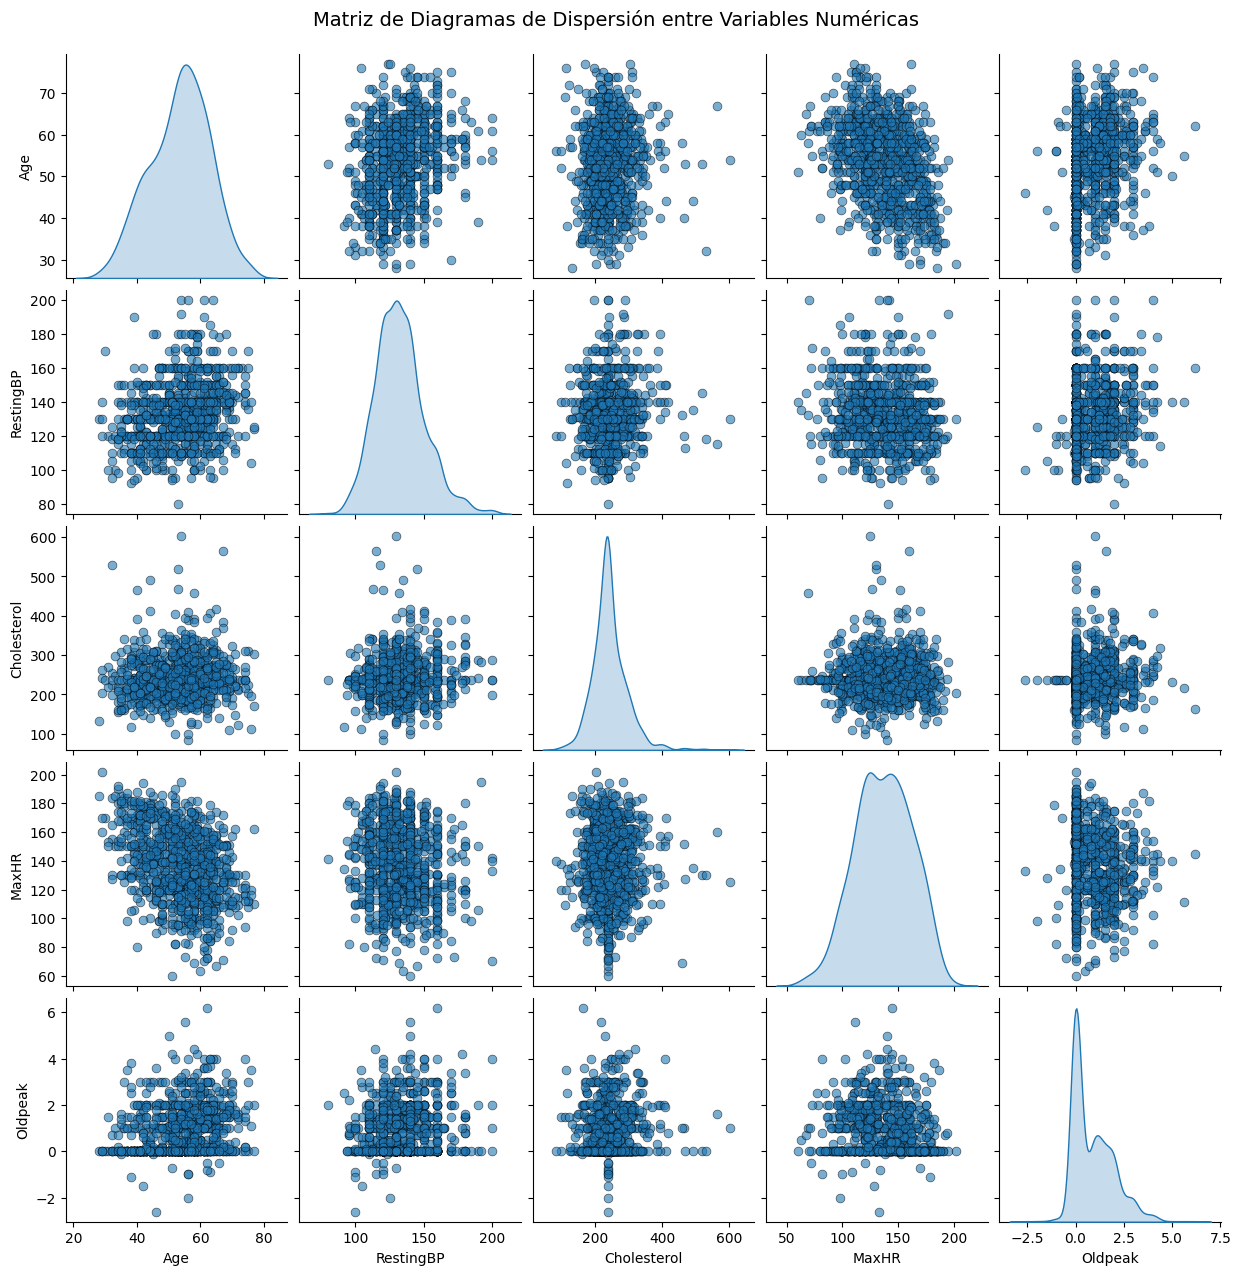

In [ ]:
# Matriz de diagramas de dispersión
sns.pairplot(df[num_cols], diag_kind='kde', plot_kws={'alpha':0.6, 's':40, 'edgecolor':'k'})
plt.suptitle('Matriz de Diagramas de Dispersión entre Variables Numéricas', y=1.02, fontsize=14)
plt.show()

Las variables numéricas presentan principalmente distribuciones no normales, con algunas asimetrías (especialmente en **Cholesterol** y **Oldpeak**). La única relación fuerte es la correlación negativa entre **edad y frecuencia cardíaca máxima** (lo cual observábamos en la matriz de correlación). En conjunto, encontramos una alta dispersión y poca correlación entre las variables.

## **4. Preprocesamiento:**

### **4.1. Codificación Variables Categoricas:**

In [ ]:
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Verificamos el resultado
df_encoded.head()



,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,FastingBS_1,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up,HeartDisease_1
0,40,140.0,289.0,172,0.0,True,True,False,False,False,True,False,False,False,True,False
1,49,160.0,180.0,156,1.0,False,False,True,False,False,True,False,False,True,False,True
2,37,130.0,283.0,98,0.0,True,True,False,False,False,False,True,False,False,True,False
3,48,138.0,214.0,108,1.5,False,False,False,False,False,True,False,True,True,False,True
4,54,150.0,195.0,122,0.0,True,False,True,False,False,True,False,False,False,True,False


### **4.2. Escalado Variables Numéricas:**

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
num_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
df_encoded[num_cols] = scaler.fit_transform(df_encoded[num_cols])
# Verificamos el resultado
df_encoded.head()


,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,FastingBS_1,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up,HeartDisease_1
0,-1.433140,0.415002,0.858035,1.382928,-0.832432,True,True,False,False,False,True,False,False,False,True,False
1,-0.478484,1.527329,-1.184227,0.754157,0.105664,False,False,True,False,False,True,False,False,True,False,True
2,-1.751359,-0.141161,0.745617,-1.525138,-0.832432,True,True,False,False,False,False,True,False,False,True,False
3,-0.584556,0.303769,-0.547191,-1.132156,0.574711,False,False,False,False,False,True,False,True,True,False,True
4,0.051881,0.971166,-0.903182,-0.581981,-0.832432,True,False,True,False,False,True,False,False,False,True,False


### **4.3. Dividir Train & Test:**

In [ ]:
df_encoded.to_csv("heart_preprocessed.csv", index=False)

In [ ]:
X = df_encoded.drop("HeartDisease_1", axis=1)
y = df_encoded["HeartDisease_1"]

### **4.4. Definir Funciones con y sin Data Leakage:**

In [ ]:
def evaluar_modelo_con_fuga(X, y, modelo, param_grid, model_name="Modelo con fuga", random_state=0):
    """
    Evalúa un modelo con fuga de datos y muestra un análisis completo (AUC, accuracy, matriz, ROC, etc.)
    """
    np.random.seed(random_state)
    X = X.copy()

    # 1️⃣ Crear variable con fuga
    X["leaky_feature"] = y + np.random.normal(0, 0.01, size=len(y))

    # 2️⃣ Escalar antes del split (introduce fuga)
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # 3️⃣ Dividir datos
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=random_state
    )

    # 4️⃣ GridSearchCV
    grid = GridSearchCV(modelo, param_grid=param_grid, cv=5, scoring="roc_auc")
    grid.fit(X_train, y_train)

    # 5️⃣ Predicciones
    y_pred = grid.predict(X_test)
    y_prob = grid.predict_proba(X_test)[:, 1]

    # 6️⃣ Métricas
    auc = roc_auc_score(y_test, y_prob)
    acc = accuracy_score(y_test, y_pred)

    print("="*70)
    print(f"🔹 {model_name}")
    print("="*70)
    print(f"Mejores parámetros encontrados: {grid.best_params_}")
    print(f"AUC (validación cruzada): {grid.best_score_:.4f}")
    print(f"AUC (test): {auc:.4f}")
    print(f"Accuracy (test): {acc:.4f}")
    print("\n📋 Reporte de Clasificación:")
    print(classification_report(y_test, y_pred, digits=4))

    # 7️⃣ Matriz de confusión
    plt.figure(figsize=(4, 3))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')
    plt.show()

    # 8️⃣ Curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("Tasa de Falsos Positivos")
    plt.ylabel("Tasa de Verdaderos Positivos")
    plt.title(f"Curva ROC - {model_name}")
    plt.legend(loc="lower right")
    plt.show()

    return {"AUC_test": auc, "Accuracy_test": acc, "best_params": grid.best_params_}


In [ ]:
def evaluar_modelo_sin_fuga(X, y, modelo, param_grid, model_name="Modelo sin fuga", random_state=0):
    """
    Evalúa un modelo SIN fuga de datos, usando un Pipeline con MinMaxScaler, e imprime un análisis completo.
    """
    np.random.seed(random_state)

    # 1️⃣ Dividir antes de escalar (flujo correcto)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=random_state
    )

    # 2️⃣ Pipeline
    pipe = Pipeline([
        ("scaler", MinMaxScaler()),
        ("modelo", modelo)
    ])

    # 3️⃣ GridSearchCV
    grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, scoring="roc_auc")
    grid.fit(X_train, y_train)

    # 4️⃣ Predicciones
    y_pred = grid.predict(X_test)
    y_prob = grid.predict_proba(X_test)[:, 1]

    # 5️⃣ Métricas
    auc = roc_auc_score(y_test, y_prob)
    acc = accuracy_score(y_test, y_pred)

    print("="*70)
    print(f"🔹 {model_name}")
    print("="*70)
    print(f"Mejores parámetros encontrados: {grid.best_params_}")
    print(f"AUC (validación cruzada): {grid.best_score_:.4f}")
    print(f"AUC (test): {auc:.4f}")
    print(f"Accuracy (test): {acc:.4f}")
    print("\n📋 Reporte de Clasificación:")
    print(classification_report(y_test, y_pred, digits=4))

    # 6️⃣ Matriz de confusión
    plt.figure(figsize=(4, 3))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')
    plt.show()

    # 7️⃣ Curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("Tasa de Falsos Positivos")
    plt.ylabel("Tasa de Verdaderos Positivos")
    plt.title(f"Curva ROC - {model_name}")
    plt.legend(loc="lower right")
    plt.show()

    return {"AUC_test": auc, "Accuracy_test": acc, "best_params": grid.best_params_}


## **5. Modelos:**

### **5.1.Logistic Regressión:**

#### **5.1.1. Con Data Leakage:**

🔹 Modelo con fuga
Mejores parámetros encontrados: {'C': 0.1}
AUC (validación cruzada): 1.0000
AUC (test): 1.0000
Accuracy (test): 1.0000

📋 Reporte de Clasificación:
              precision    recall  f1-score   support

       False     1.0000    1.0000    1.0000        77
        True     1.0000    1.0000    1.0000       107

    accuracy                         1.0000       184
   macro avg     1.0000    1.0000    1.0000       184
weighted avg     1.0000    1.0000    1.0000       184



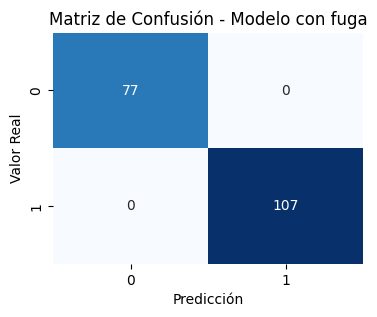

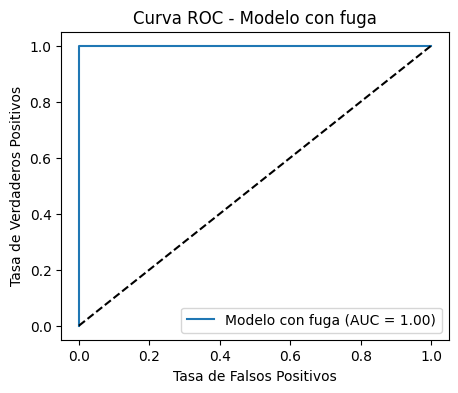

AUC con fuga (LogisticRegression): {'AUC_test': np.float64(1.0), 'Accuracy_test': 1.0, 'best_params': {'C': 0.1}}


In [ ]:
from sklearn.linear_model import LogisticRegression

auc_con_fuga = evaluar_modelo_con_fuga(
    X, y,
    modelo=LogisticRegression(max_iter=1000),
    param_grid={"C": [0.01, 0.1, 1, 10]}
)

print("AUC con fuga (LogisticRegression):", auc_con_fuga)


El conjunto de resultados del modelo de regresión logística, incluyendo un **AUC de 1.0000** y una **Accuracy de 1.0000**, junto con una matriz de confusión que muestra cero errores **(0 Falsos Positivos y 0 Falsos Negativos)**, indica de manera concluyente la presencia de Data Leakage (fuga de datos). Este rendimiento perfecto, confirmado por un reporte de clasificación con **precisión, recall y f1-score de 1.0000** para ambas clases, es irrealizable en un problema de clasificación práctico y significa que el modelo accedió a información que está directamente correlacionada con la variable objetivo y que no estaría disponible en un escenario de predicción real. Por lo tanto, **el modelo no tiene valor predictivo**.

#### **5.1.2. Sin Data Leakage:**

🔹 Modelo sin fuga
Mejores parámetros encontrados: {'modelo__C': 1}
AUC (validación cruzada): 0.9273
AUC (test): 0.9012
Accuracy (test): 0.8152

📋 Reporte de Clasificación:
              precision    recall  f1-score   support

       False     0.8209    0.7143    0.7639        77
        True     0.8120    0.8879    0.8482       107

    accuracy                         0.8152       184
   macro avg     0.8164    0.8011    0.8061       184
weighted avg     0.8157    0.8152    0.8129       184



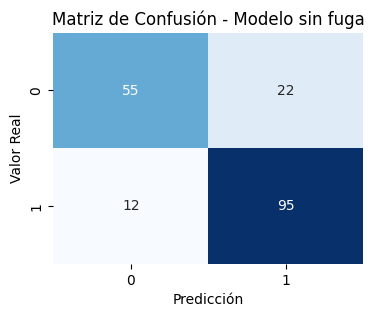

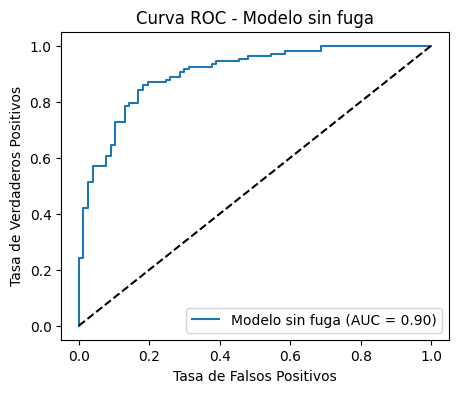

AUC sin fuga (LogisticRegression): {'AUC_test': np.float64(0.9012016021361816), 'Accuracy_test': 0.8152173913043478, 'best_params': {'modelo__C': 1}}


In [ ]:
from sklearn.linear_model import LogisticRegression

auc_sin_fuga = evaluar_modelo_sin_fuga(
    X, y,
    modelo=LogisticRegression(max_iter=1000),
    param_grid={"modelo__C": [0.01, 0.1, 1, 10]}
)

print("AUC sin fuga (LogisticRegression):", auc_sin_fuga)


El conjunto de resultados del **Modelo sin fuga** de regresión logística es significativamente más realista y útil, presentando un rendimiento de prueba sólido con una **Accuracy de 0.8152** y un **AUC de 0.9012**. La matriz de confusión demuestra un buen equilibrio predictivo, con **12 Falsos Negativos** (clase 1 mal clasificada como 0) y **22 Falsos Positivos** (clase 0 mal clasificada como 1).  El reporte de clasificación muestra que el modelo es ligeramente mejor en la identificación de la clase **'True'** (clase 1), logrando un **Recall de 0.8879** (identificando casi el 89% de los casos reales de clase 1), en comparación con la clase **'False'** (clase 0), cuyo *Recall* es de **0.7143**.  Este rendimiento indica un modelo de **buena calidad predictiva**, sin la sospecha de *Data Leakage*, siendo el *AUC* de $0.90$ un excelente indicador de la capacidad del modelo para separar correctamente las dos clases.

### **5.2. RandomForestClassifier:**

#### **5.2.1. Con Data Leakage:**

🔹 RandomForestClassifier (con fuga)
Mejores parámetros encontrados: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
AUC (validación cruzada): 1.0000
AUC (test): 1.0000
Accuracy (test): 1.0000

📋 Reporte de Clasificación:
              precision    recall  f1-score   support

       False     1.0000    1.0000    1.0000        77
        True     1.0000    1.0000    1.0000       107

    accuracy                         1.0000       184
   macro avg     1.0000    1.0000    1.0000       184
weighted avg     1.0000    1.0000    1.0000       184



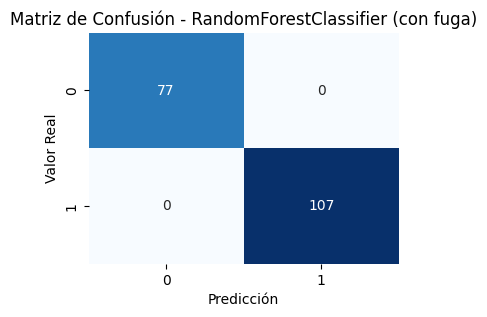

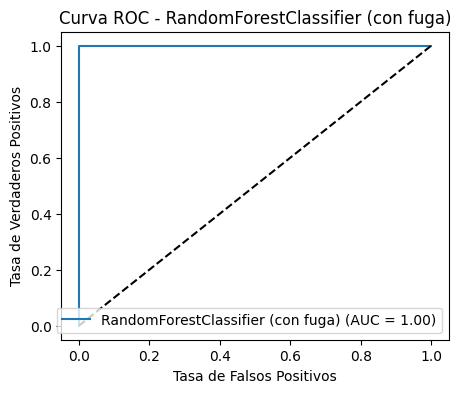

In [ ]:
from sklearn.ensemble import RandomForestClassifier

res_fuga = evaluar_modelo_con_fuga(
    X, y,
    modelo=RandomForestClassifier(random_state=0),
    param_grid={
        "n_estimators": [100, 200],
        "max_depth": [None, 5, 10],
        "min_samples_split": [2, 5]
    },
    model_name="RandomForestClassifier (con fuga)"
)

El conjunto de resultados para el **RandomForestClassifier (con fuga)**, muestra un **AUC de 1.0000** y una **Accuracy de 1.0000**. La matriz de confusión  confirma este rendimiento irreal, con **cero errores** (0 Falsos Positivos y 0 Falsos Negativos). Este desempeño perfecto, respaldado por un reporte de clasificación con **precisión, *recall* y *f1-score* de 1.0000** para ambas clases, es imposible de lograr en un problema de clasificación real y robusto, confirmando que el modelo ha aprendido una regla simple a partir de una variable que se filtró al proceso de entrenamiento. Por lo tanto, a pesar de ser un *Random Forest*, **el modelo no tiene valor predictivo real**.

#### **5.2.2.  Sin Data Leakage:**

🔹 RandomForestClassifier (sin fuga)
Mejores parámetros encontrados: {'modelo__max_depth': None, 'modelo__min_samples_split': 5, 'modelo__n_estimators': 200}
AUC (validación cruzada): 0.9268
AUC (test): 0.9084
Accuracy (test): 0.8424

📋 Reporte de Clasificación:
              precision    recall  f1-score   support

       False     0.8333    0.7792    0.8054        77
        True     0.8482    0.8879    0.8676       107

    accuracy                         0.8424       184
   macro avg     0.8408    0.8335    0.8365       184
weighted avg     0.8420    0.8424    0.8415       184



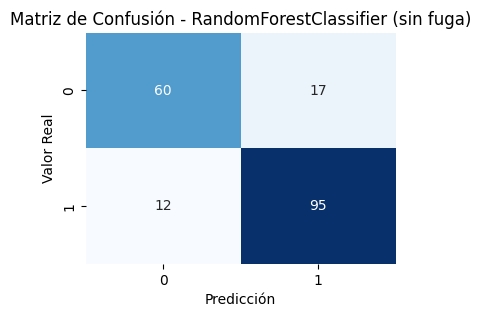

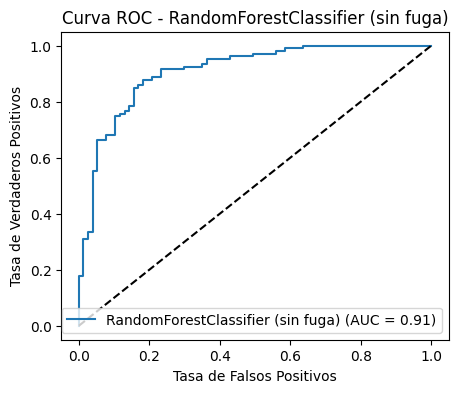

In [ ]:
res_sin_fuga = evaluar_modelo_sin_fuga(
    X, y,
    modelo=RandomForestClassifier(random_state=0),
    param_grid={
        "modelo__n_estimators": [100, 200],
        "modelo__max_depth": [None, 5, 10],
        "modelo__min_samples_split": [2, 5]
    },
    model_name="RandomForestClassifier (sin fuga)"
)

El conjunto de resultados para el **RandomForestClassifier (sin fuga)** presenta un modelo de **excelente rendimiento predictivo y realista**, logrando una **Accuracy de 0.8424** y un **AUC de 0.9084**, superando ligeramente la *Accuracy* y el *AUC* del modelo de regresión logística sin fuga. La matriz de confusión  muestra un buen desempeño con **12 Falsos Negativos** (clase 1 mal clasificada como 0) y **17 Falsos Positivos** (clase 0 mal clasificada como 1), siendo los *Falsos Positivos* ligeramente menores que en el modelo anterior. El reporte de clasificación indica que el modelo continúa siendo marginalmente más efectivo en la identificación de la clase **'True'** (clase 1), con un **Recall de 0.8879**, mientras que la clase **'False'** (clase 0) obtiene una **Precisión de 0.8333**, confirmando que, al igual que el modelo de regresión logística, este *Random Forest* ofrece una **alta capacidad de discriminación** entre clases y es un modelo robusto para predicciones reales.

### **5.3 K-Nearest Neighbors:**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

#### **5.3.1. Con Data Leakage:**

🔹 KNeighborsClassifier (con fuga)
Mejores parámetros encontrados: {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
AUC (validación cruzada): 0.9966
AUC (test): 0.9968
Accuracy (test): 0.9728

📋 Reporte de Clasificación:
              precision    recall  f1-score   support

       False     0.9737    0.9610    0.9673        77
        True     0.9722    0.9813    0.9767       107

    accuracy                         0.9728       184
   macro avg     0.9730    0.9712    0.9720       184
weighted avg     0.9728    0.9728    0.9728       184



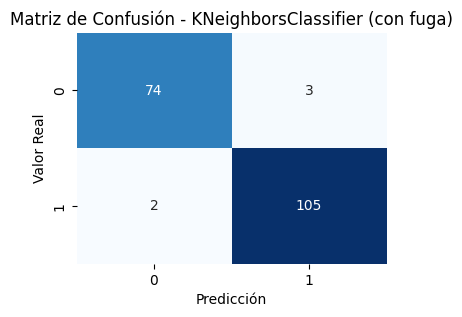

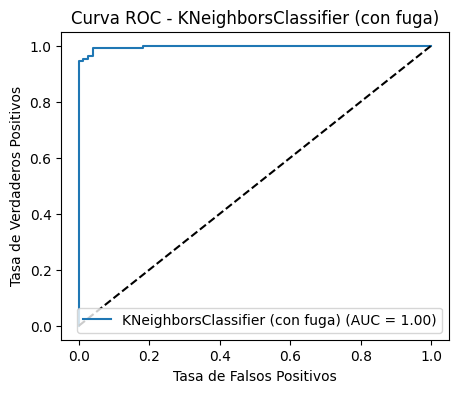

In [ ]:
res_fuga = evaluar_modelo_con_fuga(
    X, y,
    modelo=KNeighborsClassifier(),
    param_grid={
        "n_neighbors": [3, 5, 7, 9],
        "weights": ["uniform", "distance"],
        "p": [1, 2]  # 1=Manhattan, 2=Euclidiana
    },
    model_name="KNeighborsClassifier (con fuga)"
)

El conjunto de resultados para el **KNeighborsClassifier (con fuga)** muestra un rendimiento extremadamente alto, con un **AUC de 0.9968** y una **Accuracy de 0.9728**, lo que indica de manera concluyente la **alta probabilidad de Data Leakage (fuga de datos)**, aunque en una forma menos severa que los modelos anteriores con puntuaciones perfectas. La matriz de confusión  registra **5 errores** en total (**3 Falsos Positivos** y **2 Falsos Negativos**), lo que le permite alcanzar una *Accuracy* de más del 97%. El reporte de clasificación confirma este rendimiento casi perfecto con una **precisión, *recall* y *f1-score*** en el rango de $0.96$ a $0.98$ para ambas clases. A pesar de que los errores son mínimos, un rendimiento tan cercano al 100% en un problema de clasificación real sugiere fuertemente que el modelo está utilizando información filtrada que no estaría disponible en producción. Por lo tanto, el modelo, aunque no es perfecto, **no es un predictor confiable** hasta que se resuelva la fuga de datos.

#### **5.3.2.  Sin Data Leakage:**

🔹 KNeighborsClassifier (sin fuga)
Mejores parámetros encontrados: {'modelo__n_neighbors': 9, 'modelo__p': 2, 'modelo__weights': 'distance'}
AUC (validación cruzada): 0.9079
AUC (test): 0.8881
Accuracy (test): 0.8043

📋 Reporte de Clasificación:
              precision    recall  f1-score   support

       False     0.7971    0.7143    0.7534        77
        True     0.8087    0.8692    0.8378       107

    accuracy                         0.8043       184
   macro avg     0.8029    0.7917    0.7956       184
weighted avg     0.8038    0.8043    0.8025       184



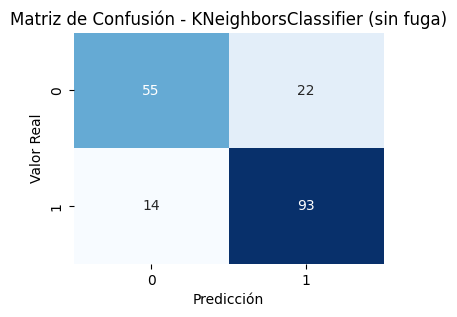

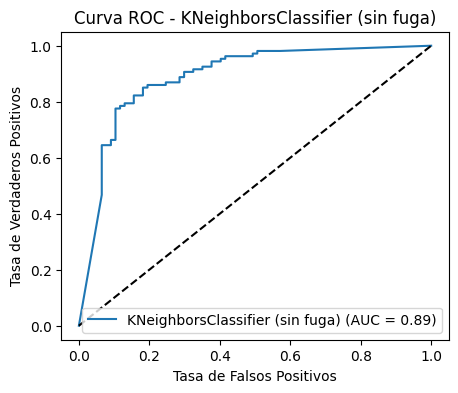

In [ ]:
res_sin_fuga = evaluar_modelo_sin_fuga(
    X, y,
    modelo=KNeighborsClassifier(),
    param_grid={
        "modelo__n_neighbors": [3, 5, 7, 9],
        "modelo__weights": ["uniform", "distance"],
        "modelo__p": [1, 2]
    },
    model_name="KNeighborsClassifier (sin fuga)"
)

El conjunto de resultados para el **KNeighborsClassifier (sin fuga)** presenta un rendimiento **aceptable y realista**, con una **Accuracy de 0.8043** y un **AUC de 0.8881**, lo cual es un indicador de que el modelo tiene buena capacidad de discriminación. La matriz de confusión  refleja un balance en los errores, con **14 Falsos Negativos** (clase 1 mal clasificada como 0) y **22 Falsos Positivos** (clase 0 mal clasificada como 1). El reporte de clasificación muestra que, al igual que los otros modelos, es mejor prediciendo la clase **'True'** (clase 1), logrando un alto **Recall de 0.8692** (identificando casi el 87% de los casos reales de clase 1), mientras que la clase **'False'** (clase 0) obtiene una **Precisión de 0.7971**. En general, este modelo **KNN sin fuga** es un predictor útil y validado.

### **5.4. Gradient Boosting Classifier:**

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

#### **5.4.1. Con Data Leakage:**

🔹 GradientBoostingClassifier (con fuga)
Mejores parámetros encontrados: {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 50}
AUC (validación cruzada): 1.0000
AUC (test): 1.0000
Accuracy (test): 1.0000

📋 Reporte de Clasificación:
              precision    recall  f1-score   support

       False     1.0000    1.0000    1.0000        77
        True     1.0000    1.0000    1.0000       107

    accuracy                         1.0000       184
   macro avg     1.0000    1.0000    1.0000       184
weighted avg     1.0000    1.0000    1.0000       184



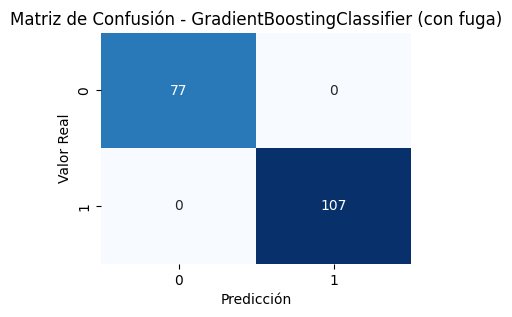

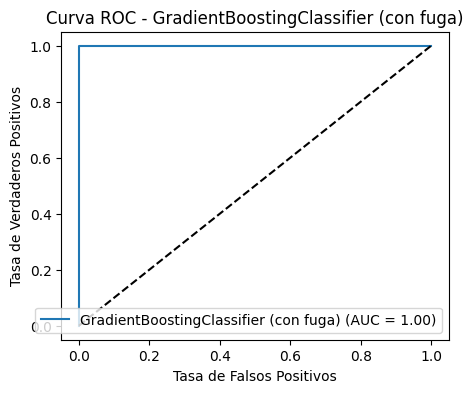

In [ ]:
res_fuga = evaluar_modelo_con_fuga(
    X, y,
    modelo=GradientBoostingClassifier(random_state=0),
    param_grid={
        "n_estimators": [50, 100, 150],
        "learning_rate": [0.01, 0.05, 0.1],
        "max_depth": [2, 3, 4]
    },
    model_name="GradientBoostingClassifier (con fuga)"
)

El conjunto de resultados para el **GradientBoostingClassifier (con fuga)** alcanza un **AUC de 1.0000** y un **Accuracy de 1.0000**. La matriz de confusión  exhibe **cero errores** (**0 Falsos Positivos y 0 Falsos Negativos**), lo que establece de manera inequívoca la **presencia severa de Data Leakage (fuga de datos)** en el conjunto de datos. Este rendimiento perfectamente irreal, confirmado por un reporte de clasificación con **precisión, *recall* y *f1-score* de 1.0000** para ambas clases, significa que el modelo de *Gradient Boosting* está utilizando información filtrada que le da una ventaja injusta para clasificar las instancias. Por lo tanto, aunque la técnica de *Gradient Boosting* es avanzada, **el modelo no tiene ninguna validez predictiva real**.

#### **5.4.2.  Sin Data Leakage:**

🔹 GradientBoostingClassifier (sin fuga)
Mejores parámetros encontrados: {'modelo__learning_rate': 0.05, 'modelo__max_depth': 3, 'modelo__n_estimators': 100}
AUC (validación cruzada): 0.9315
AUC (test): 0.9179
Accuracy (test): 0.8587

📋 Reporte de Clasificación:
              precision    recall  f1-score   support

       False     0.8592    0.7922    0.8243        77
        True     0.8584    0.9065    0.8818       107

    accuracy                         0.8587       184
   macro avg     0.8588    0.8494    0.8531       184
weighted avg     0.8587    0.8587    0.8578       184



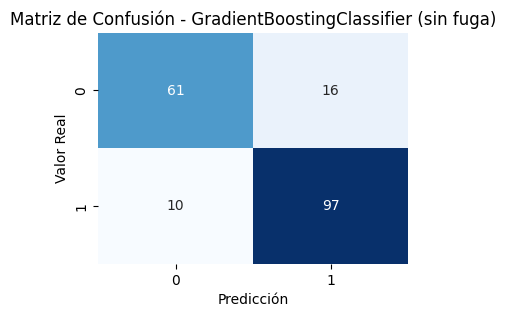

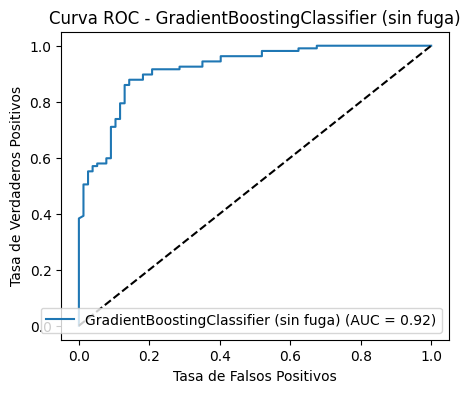

In [ ]:
res_sin_fuga = evaluar_modelo_sin_fuga(
    X, y,
    modelo=GradientBoostingClassifier(random_state=0),
    param_grid={
        "modelo__n_estimators": [50, 100, 150],
        "modelo__learning_rate": [0.01, 0.05, 0.1],
        "modelo__max_depth": [2, 3, 4]
    },
    model_name="GradientBoostingClassifier (sin fuga)"
)

El conjunto de resultados para el **GradientBoostingClassifier (sin fuga)** logra un *Accuracy* de **0.8587** y un **AUC de 0.9179**, lo que confirma una capacidad de discriminación excelente y un modelo robusto. La matriz de confusión  muestra el menor número de errores entre los modelos realistas, con solo **10 Falsos Negativos** (clase 1 mal clasificada como 0) y **16 Falsos Positivos** (clase 0 mal clasificada como 1). El reporte de clasificación destaca un **Recall** sobresaliente para la clase **'True'** (clase 1) de **0.9065**, identificando correctamente más del 90% de los casos positivos reales, mientras que la clase **'False'** (clase 0) mantiene una **Precisión de 0.8592**. Por lo tanto, este modelo de *Gradient Boosting* es un **predictor potente y confiable**.

### **5.5. SVM:**

In [ ]:
from sklearn.svm import SVC

#### **5.5.1. Con Data Leakage:**

🔹 SVC (con fuga)
Mejores parámetros encontrados: {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
AUC (validación cruzada): 1.0000
AUC (test): 1.0000
Accuracy (test): 1.0000

📋 Reporte de Clasificación:
              precision    recall  f1-score   support

       False     1.0000    1.0000    1.0000        77
        True     1.0000    1.0000    1.0000       107

    accuracy                         1.0000       184
   macro avg     1.0000    1.0000    1.0000       184
weighted avg     1.0000    1.0000    1.0000       184



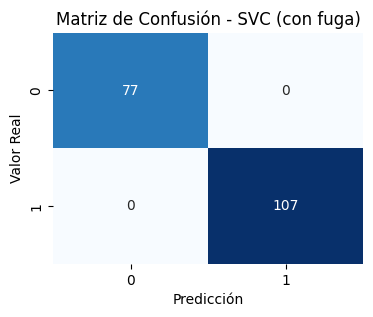

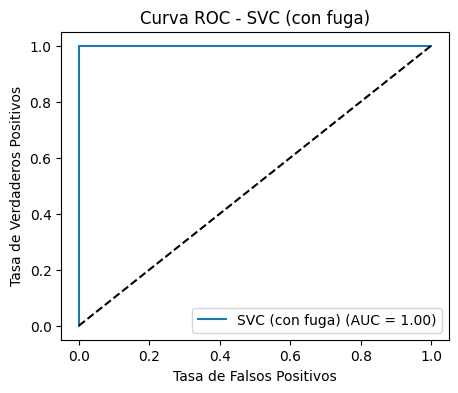

In [ ]:
res_fuga = evaluar_modelo_con_fuga(
    X, y,
    modelo=SVC(probability=True),
    param_grid={
        "C": [0.1, 1, 10],
        "gamma": [0.01, 0.1, 1],
        "kernel": ["rbf", "poly"]
    },
    model_name="SVC (con fuga)"
)

El conjunto de resultados para el **SVC (Support Vector Classifier) con fuga** presenta, un **AUC de 1.0000** y una **Accuracy de 1.0000**. La matriz de confusión  exhibe **cero errores** (**0 Falsos Positivos y 0 Falsos Negativos**), lo cual, a pesar de usar una técnica de clasificación diferente, establece de forma concluyente la **presencia severa de Data Leakage (fuga de datos)** en el conjunto de datos. Este rendimiento perfectamente irreal, confirmado por un reporte de clasificación con **precisión, *recall* y *f1-score* de 1.0000** para ambas clases, indica que el modelo **no es un predictor válido** y está utilizando información filtrada que le permite clasificar todas las instancias sin cometer errores. Por lo tanto, el modelo SVC, al igual que los demás modelos "con fuga", **carece de valor predictivo**.

#### **5.5.2. Sin Data Leakage:**

🔹 SVC (sin fuga)
Mejores parámetros encontrados: {'modelo__C': 10, 'modelo__gamma': 0.1, 'modelo__kernel': 'rbf'}
AUC (validación cruzada): 0.9246
AUC (test): 0.9029
Accuracy (test): 0.8315

📋 Reporte de Clasificación:
              precision    recall  f1-score   support

       False     0.8286    0.7532    0.7891        77
        True     0.8333    0.8879    0.8597       107

    accuracy                         0.8315       184
   macro avg     0.8310    0.8205    0.8244       184
weighted avg     0.8313    0.8315    0.8302       184



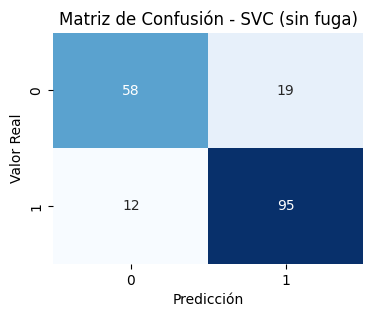

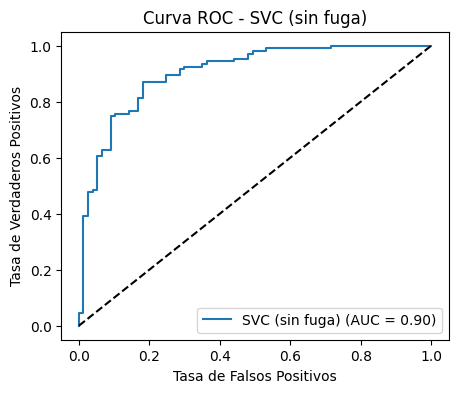

In [ ]:
res_sin_fuga = evaluar_modelo_sin_fuga(
    X, y,
    modelo=SVC(probability=True),
    param_grid={
        "modelo__C": [0.1, 1, 10],
        "modelo__gamma": [0.01, 0.1, 1],
        "modelo__kernel": ["rbf", "poly"]
    },
    model_name="SVC (sin fuga)"
)

El conjunto de resultados para el **SVC (Support Vector Classifier) sin fuga** presenta un rendimiento **fuerte y confiable**, con una **Accuracy de 0.8315** y un **AUC de 0.9029**, lo que confirma su **excelente capacidad de discriminación** entre clases. La matriz de confusión  muestra un buen equilibrio en los errores, con **12 Falsos Negativos** (clase 1 mal clasificada como 0) y **19 Falsos Positivos** (clase 0 mal clasificada como 1). El reporte de clasificación destaca que el SVC, al igual que los demás, es más eficaz prediciendo la clase **'True'** (clase 1), logrando un **Recall de 0.8879**, es decir, identificando a casi el 89% de los casos positivos reales, mientras que la clase **'False'** (clase 0) obtiene un *Recall* de **0.7532**. En resumen, el **SVC sin fuga** es un predictor **sólido y validado**.

## **6. Comparación de los Modelos sin Fuga de Datos**

| Clasificación | Modelo | AUC (Test) | Accuracy (Test) | F1-Score (Promedio Ponderado) |
| :---: | :--- | :---: | :---: | :---: |
| **1 (Mejor)** | **GradientBoostingClassifier** | **0.9179** | **0.8587** | **0.8578** |
| 2 | RandomForestClassifier | 0.9084 | 0.8424 | 0.8415 |
| 3 | SVC | 0.9029 | 0.8315 | 0.8302 |
| 4 | Regresión Logística | 0.9012 | 0.8152 | 0.8129 |
| **5 (Peor)** | KNeighborsClassifier | 0.8881 | 0.8043 | 0.8025 |

1. **GradientBoostingClassifier** es el mejor modelo en general, ya que logró el valor más alto en las tres métricas principales: AUC (0.9179), Accuracy (0.8587) y F1-Score (0.8578).

2. El **RandomForestClassifier** es un competidor muy cercano, con un rendimiento excelente que se queda justo detrás del Gradient Boosting.

3. El **KNeighborsClassifier** mostró el rendimiento más bajo en todas las métricas, aunque su AUC de 0.8881 sigue siendo considerado un buen rendimiento.